# RoPE

Paper: https://arxiv.org/pdf/2104.09864

TODO:
- Paper says: "RoPE proposes to incorporate the relative position information by multiplying with the sinusoidal functions". Learn more about it.
- The attention scores b/w "cats" and "dogs" should not change for these two sentences: "Abram likes cats and dogs" and "cats and dogs like Abram". But it should be different for "Abram likes dogs and cats" or "cats like Abram and dogs".
- Can we test the perplexity experiment with RoPE and Sinusoidal embeddings?
- Can we test the decaying inter-token dependency experiment with RoPE and Sinusoidal embeddings?
- Can we test the sequence length flexibility experiment?

Consider a rotation angle as positional information.

Say the interval is t = 15 degrees.

Then the rotation for first token is 0 degrees, for second token is 15 degrees, for third token is 30 degrees and so on.

To illustrate this, let's take 2D embeddings of for the following sentence: "cats do not like dogs".

Notes:
- They are applied at every layer.

### Problems:

- For certain intervals, the rotation overlaps. For example, rotating a vector by 15 degrees and 375 degrees is the same.
- Rotation changes the meaning of the embeddings. The original vector "banana" might now mean "dog".
- Rotation for high dimensions is computationally expensive.

### Solutions:

- Instead of using Euler space, we use Complex space i.e. numbers of the form `a + bi`.
    - How do we convert from Euler space to Complex space?


### Advantages of RoPE:
- Sequence length flexibility.
    - Can go beyond trained sequence length
    - Perplexity increased slowly with increasing sequence length compared to sinusoidal embeddings.
- Decaying inter-token dependency.
    - The dependency between tokens decreases as the distance between them increases.


In [76]:
from typing import Tuple

import torch
from matplotlib import pyplot as plt

# RoPE implementation from llama code

The first precompute the thetas and then use them to compute the positional embeddings.

A new theta for every item in the sequence length and for every embedding dimension / 2.


In [2]:
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    """
    Precompute the frequency tensor for complex exponentials (cis) with given dimensions.

    This function calculates a frequency tensor with complex exponentials using the given dimension 'dim'
    and the end index 'end'. The 'theta' parameter scales the frequencies.
    The returned tensor contains complex values in complex64 data type.

    Args:
        dim (int): Dimension of the frequency tensor.
        end (int): End index for precomputing frequencies.
        theta (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.

    Returns:
        torch.Tensor: Precomputed frequency tensor with complex exponentials.
    """
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    """
    freqs is of shape (dim // 2,)
    It starts at 1 and decreases exponentially to 1 / theta.
    For example, when dim = 256,
    freqs = [1, 0.93, 0.86, ... , ~1 / theta]
    """

    t = torch.arange(end, device=freqs.device)  # type: ignore  # (end,)
    freqs = torch.outer(t, freqs).float()  # type: ignore  # (end, dim // 2)
    """
    freqs is of shape (end, dim // 2)
    It is the outer product of t and freqs.
    t = [0, 1, 2, ..., end - 1]
    freqs (before) = [1, 0.93, 0.86, ... , ~1 / theta]
    freqs (after) = [
        0 * [1, 0.93, 0.86, ... , ~1 / theta],
        1 * [1, 0.93, 0.86, ... , ~1 / theta],
        2 * [1, 0.93, 0.86, ... , ~1 / theta],
        ...,
        (end - 1) * [1, 0.93, 0.86, ... , ~1 / theta],
    ]
    """

    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    """
    freqs_cis is of shape (end, dim // 2), but is a complex tensor.
    freqs_cis.real is of shape (end, dim // 2) and of dtype float32.
    freqs_cis.imag is of shape (end, dim // 2) and of dtype float32.

    freqs_cis.real = cos(freqs)
    freqs_cis.imag = sin(freqs)
    """
    return freqs_cis

In [3]:
n_d = 1024
n_h = 4
dim = n_d // n_h

max_seq_length = 512

dim

256

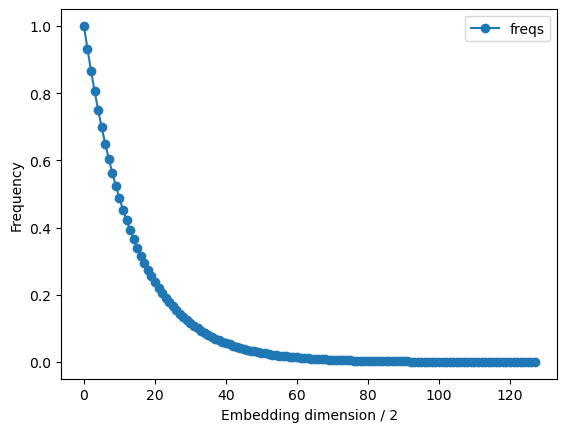

[1.0,
 0.9305720329284668,
 0.8659643530845642,
 0.8058422207832336,
 0.7498942017555237,
 0.6978305578231812,
 0.6493816375732422,
 0.6042963862419128,
 0.5623413324356079,
 0.5232991576194763,
 0.486967533826828,
 0.45315834879875183,
 0.4216965138912201,
 0.3924189805984497,
 0.36517414450645447,
 0.33982083201408386,
 0.3162277638912201,
 0.2942727208137512,
 0.2738419771194458,
 0.25482967495918274,
 0.23713736236095428,
 0.22067339718341827,
 0.20535250008106232,
 0.1910952925682068,
 0.17782793939113617,
 0.16548170149326324,
 0.1539926528930664,
 0.14330126345157623,
 0.1333521455526352,
 0.12409377098083496,
 0.11547820270061493,
 0.10746078193187714,
 0.10000000149011612,
 0.09305720031261444,
 0.08659642934799194,
 0.08058421313762665,
 0.07498941570520401,
 0.069783054292202,
 0.06493816524744034,
 0.0604296438395977,
 0.05623412877321243,
 0.05232991278171539,
 0.04869675263762474,
 0.04531583562493324,
 0.04216964915394783,
 0.03924189880490303,
 0.03651741147041321,
 0.0

In [4]:
freqs = 1.0 / (10000.0 ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))

plt.plot(freqs, "o-", label="freqs")
plt.xlabel("Embedding dimension / 2")
plt.ylabel("Frequency")
plt.legend()
plt.show()

freqs.tolist()

These are the angle multipliers. The units are in radians.

The angles go lower from left to right. So the first embedding pair has the highest frequency (rotates the fastest).
The decay is exponential

For the first position's embedding, take these and multiply with 0. That's the angles we rotate first embedding.

For second embedding, multiply with 1. We rotate by these angles. And so on.

For the last embedding, multiply with 511. So the angles are large.

This means that the embeddings that are farther in the sequence are rotated more linearly.


Summarizing table:
|  | First embedding pair | Last embedding pair | |
| --- | --- | --- | - |
| First position in the sequence | medium | very low | → Exponential decay |
| Last position in the sequence | high | low | ↓ linear increase |



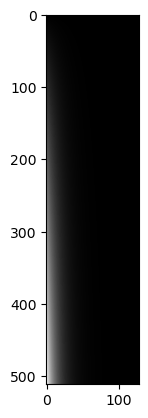

In [5]:
all_freqs = torch.outer(torch.arange(max_seq_length), freqs)  # (l, d // 2)
all_freqs = torch.rad2deg(all_freqs)
plt.imshow(all_freqs, cmap="gray")

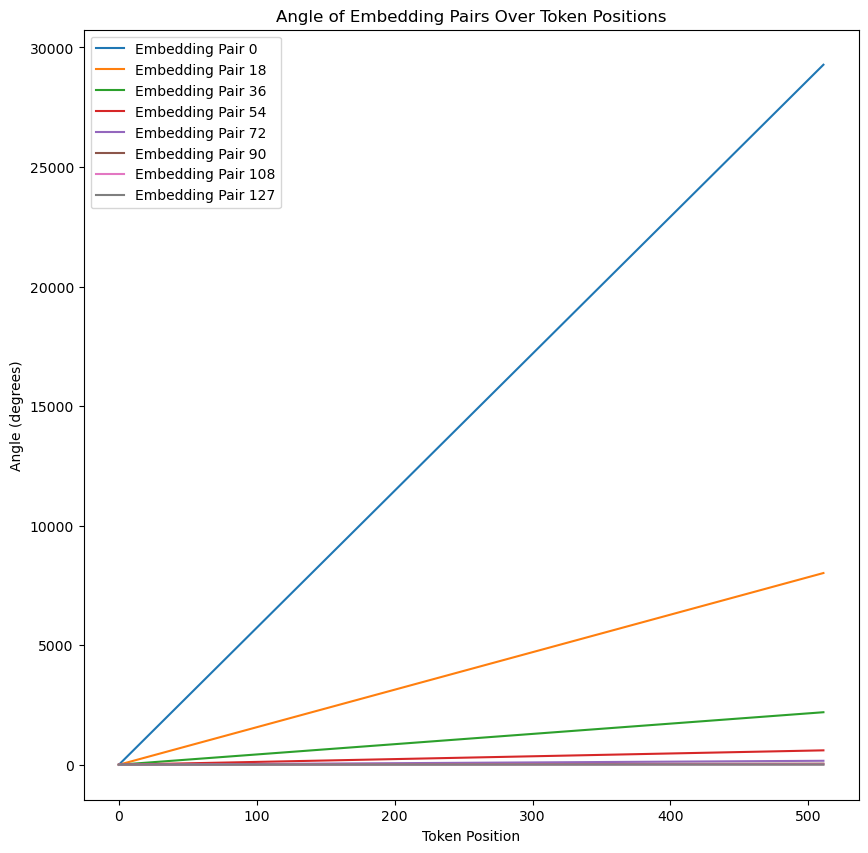

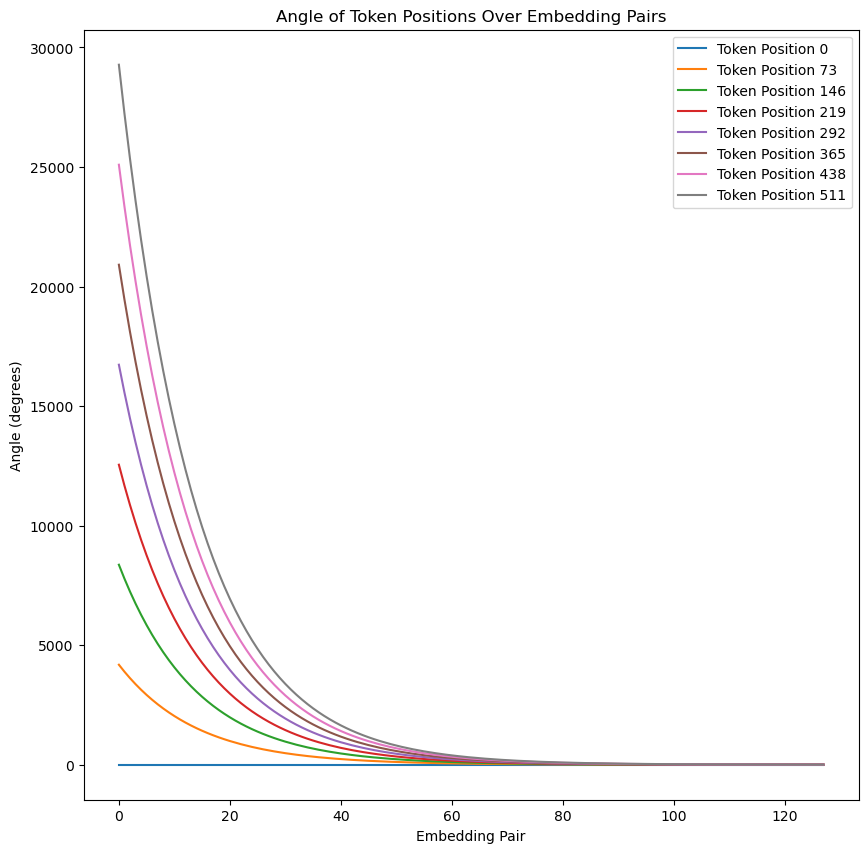

In [6]:
plt.figure(figsize=(10, 10))
n_samples = 8
sample_indices = torch.linspace(0, (dim // 2) - 1, n_samples).long()
for idx in sample_indices:
    plt.plot(all_freqs[:, idx], label=f"Embedding Pair {idx.item()}")
plt.xlabel("Token Position")
plt.ylabel("Angle (degrees)")
plt.title("Angle of Embedding Pairs Over Token Positions")
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
n_samples = 8
sample_indices = torch.linspace(0, max_seq_length - 1, n_samples).long()
for idx in sample_indices:
    plt.plot(all_freqs[idx], label=f"Token Position {idx.item()}")
plt.xlabel("Embedding Pair")
plt.ylabel("Angle (degrees)")
plt.title("Angle of Token Positions Over Embedding Pairs")
plt.legend()

Now let's see how the cos and sin of these angles look like.

In [7]:
cis = precompute_freqs_cis(dim, max_seq_length)

# cis.real is cos
# cis.imag is sin

# We expect different theta for every combination of (token position, embedding dimension per head / 2)
assert cis.shape == (max_seq_length, dim // 2)

cis.shape, cis.dtype

(torch.Size([512, 128]), torch.complex64)

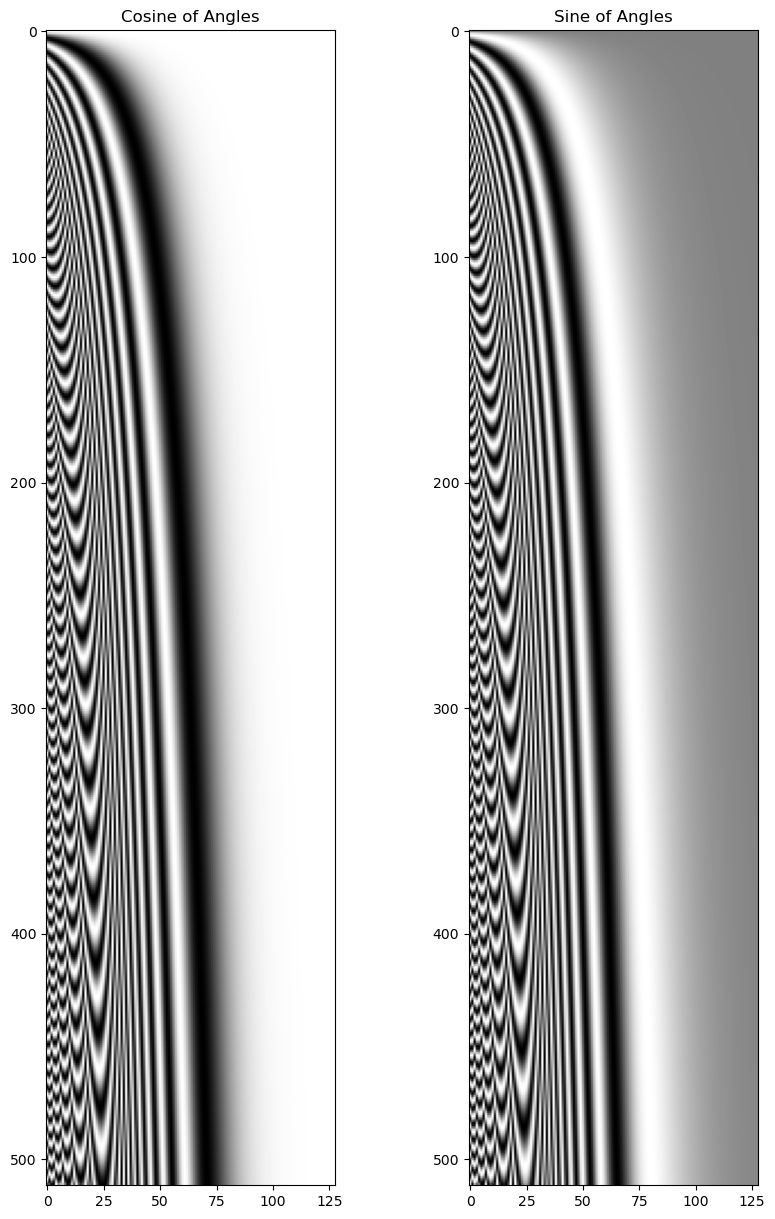

In [8]:
# Two plots side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 15))
axs[0].imshow(cis.real.numpy(), cmap="gray")
axs[0].set_title("Cosine of Angles")
axs[1].imshow(cis.imag.numpy(), cmap="gray")
axs[1].set_title("Sine of Angles")
plt.show()

That is similar to the sinusoidal positional embeddings.

We can think of it as instead of `adding` the positional embeddings to the token embeddings directly,
we `rotate` the consecutive pairs of token embedding vales by the cos and sin heatmap.

We can visualize the oscillations like this:

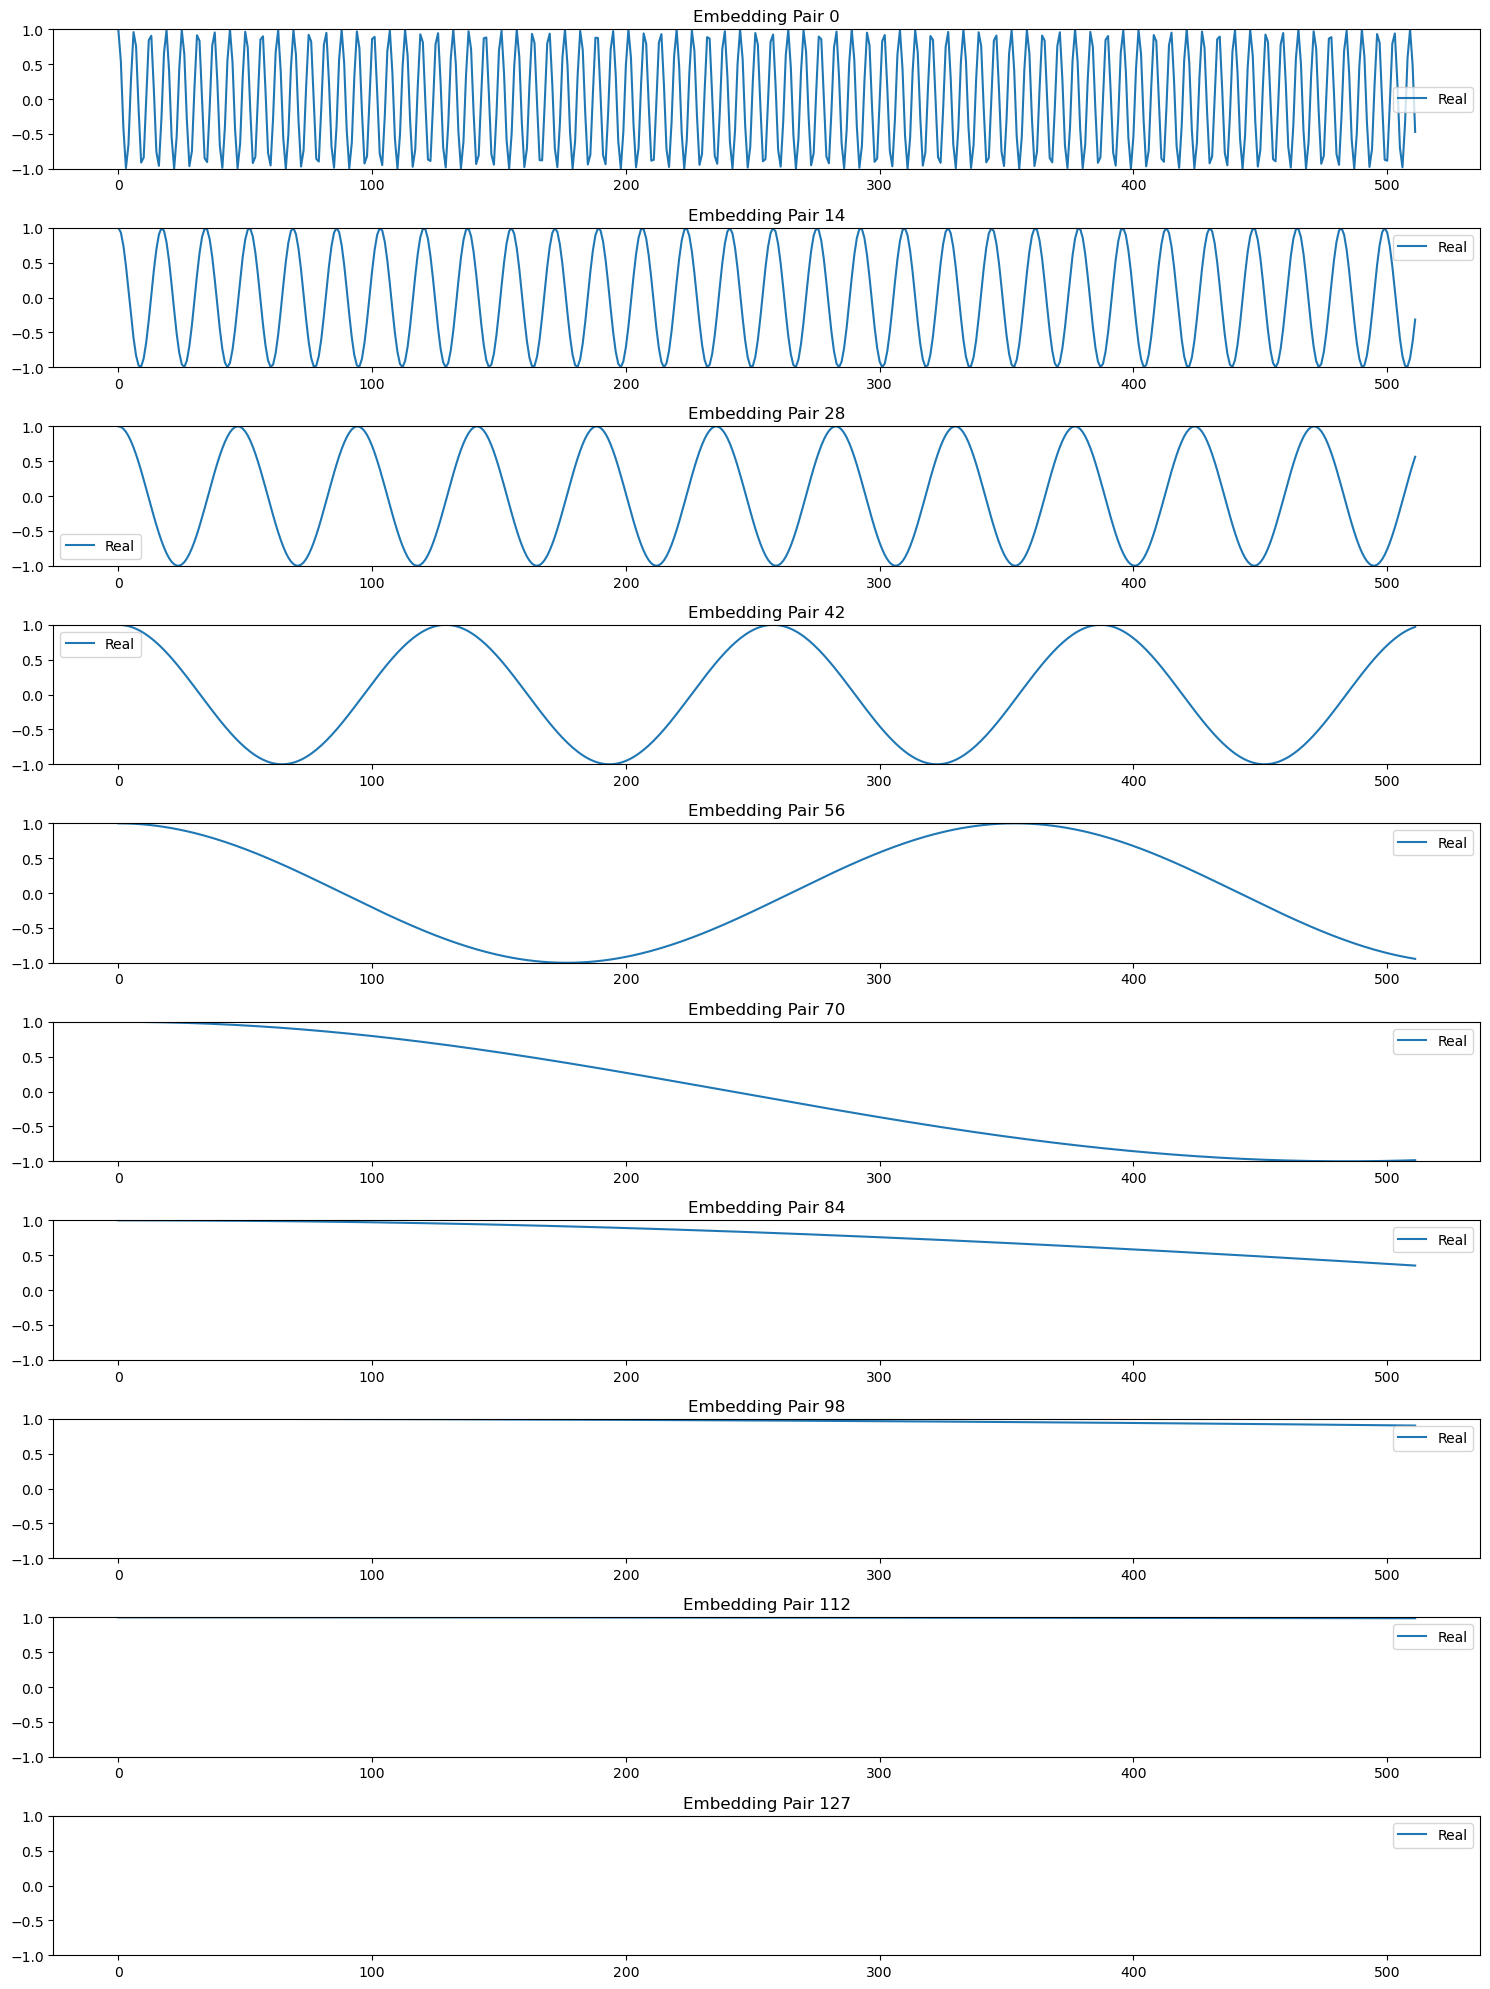

In [9]:
n_samples = 10
sample_indices = torch.linspace(0, (dim // 2) - 1, n_samples).long()

# Create a subplot with n_samples rows and 1 column
fig, axs = plt.subplots(n_samples, 1, figsize=(15, 20))
# Plot the real part of the cis for each sample
for i, idx in enumerate(sample_indices):
    axs[i].plot(cis[:, idx].real, label="Real")
    axs[i].set_title(f"Embedding Pair {idx.item()}")
    axs[i].legend()
    axs[i].set_ylim(-1, 1)
plt.tight_layout()

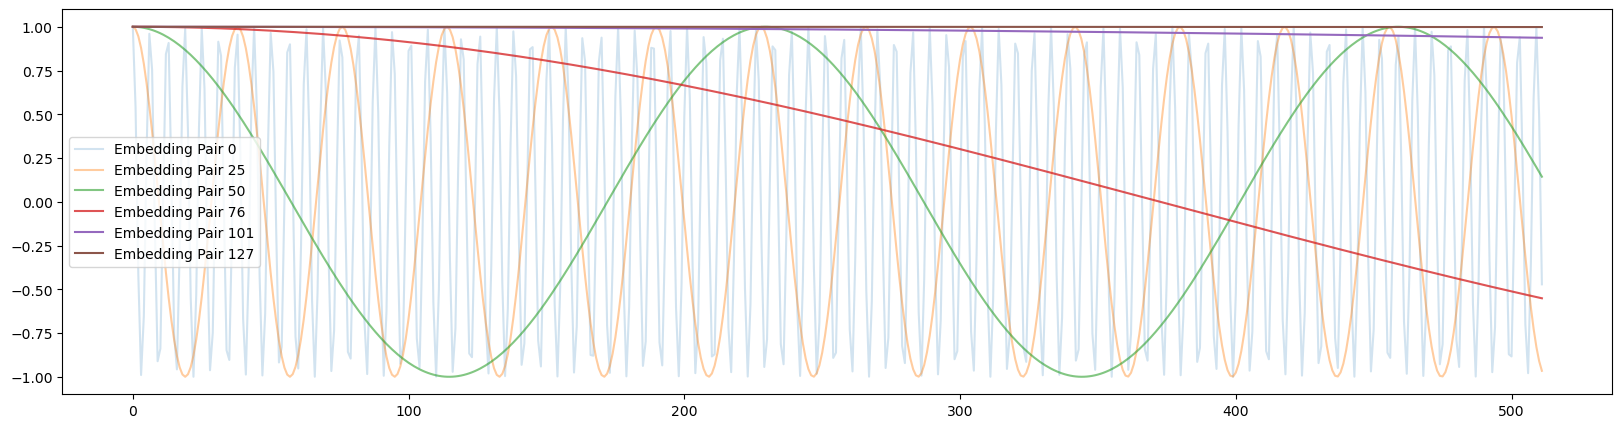

In [10]:
# plot them all in the same graph
n_samples = 6
sample_indices = torch.linspace(0, (dim // 2) - 1, n_samples).long()
plt.figure(figsize=(20, 5))
for idx in sample_indices:
    plt.plot(cis[:, idx].real, label=f"Embedding Pair {idx.item()}", alpha=min(1, 1*(idx.item() / (dim // 2) + 0.2)))
plt.legend()

Every wave unit is a full circular rotation of the 2D vector (pair of values in embedding).

The first pair is rotating very fast, second pair a bit slower, and so on.

## Now let's actually use these to rotate the embeddings.

In [23]:
def apply_rotary_emb(
        x: torch.Tensor,  # (b, l, nh, hd)
        freqs_cis: torch.Tensor,  # (l, hd // 2)
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Apply rotary embeddings to input tensors using the given frequency tensor.

    This function applies rotary embeddings to the given query 'xq' and key 'xk' tensors using the provided
    frequency tensor 'freqs_cis'. The input tensors are reshaped as complex numbers, and the frequency tensor
    is reshaped for broadcasting compatibility. The resulting tensors contain rotary embeddings and are
    returned as real tensors.

    Args:
        x (torch.Tensor): Tensor to apply rotary embeddings. (b, l, nh, hd)
        freqs_cis (torch.Tensor): Precomputed frequency tensor for complex exponentials.  (l, hd // 2)

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Tuple of modified query tensor and key tensor with rotary embeddings.
        shape: (b, l, nh, hd)

    """
    # Split into consecutive pairs
    x_ = x.float().reshape(*x.shape[:-1], -1, 2)  # (b, l, nh, hd // 2, 2)

    # Convert to complex numbers
    x_ = torch.view_as_complex(x_)  # (b, l, nh, hd // 2)
    """
    This will split the last dimension into two tensors -- real and imag parts of a complex tensor.
    (b, l, nh, hd // 2, 2) -> (b, l, nh, hd // 2)
    First of the two is the real part, second is the imaginary part.
    To get the original back, we can do
        torch.cat([xq_.real.unsqueeze(-1), xq_.imag.unsqueeze(-1)], dim=-1)
        or torch.view_as_real(xq_)
    """

    # freqs_cis = reshape_for_broadcast(freqs_cis, xq_)  # (l, hd // 2) -> (1, l, 1, hd // 2)
    freqs_cis = freqs_cis.unsqueeze(0).unsqueeze(2)  # (l, hd // 2) -> (1, l, 1, hd // 2)

    # Complex number multiplication: (a + ib) (c + id) = (ac - bd) + i(ad + bc)
    x_rotated = x_ * freqs_cis  # (b, l, nh, hd // 2)
    """
    xq_rotated = (
        (xq_.real * freqs_cis.real - xq_.imag * freqs_cis.imag)
        + i(xq_.real * freqs_cis.imag + xq_.imag * freqs_cis.real)
    )
    Since cis.real is cos and cis.imag is sin,
    xq_rotated = (
        (xq_.real * cos(radians) - xq_.imag * sin(radians))
        + i(xq_.real * sin(radians) + xq_.imag * cos(radians))
    )
    xq is rotated by radians.
    """

    x_out = torch.view_as_real(x_rotated).flatten(3)  # (b, l, nh, hd // 2, 2) -> (b, l, nh, hd)

    return x_out.type_as(x)

In [24]:
batch_size = 2
seq_len = 10

q = torch.randn(batch_size, seq_len, n_h, dim)

qr = apply_rotary_emb(q, cis[: seq_len])

qr.shape

torch.Size([2, 10, 4, 256])

In [25]:
# View first 4 pairs of embeddings for the second item in the sequence.
original = q[0, 1, 0, :8]
rotated = qr[0, 1, 0, :8]

original, rotated

(tensor([-1.2106, -0.0276, -0.7665, -0.8001, -0.7398,  0.0451, -0.4331,  0.7107]),
 tensor([-0.6308, -1.0336,  0.1838, -1.0927, -0.5136, -0.5343, -0.8126,  0.1797]))

In [26]:
# Calculate how much they rotated
for i in range(4):
    original_vector = original[2 * i : 2 * (i + 1)]
    rotated_vector = rotated[2 * i : 2 * (i + 1)]

    angle = torch.atan2(rotated_vector[1], rotated_vector[0]) - torch.atan2(original_vector[1], original_vector[0])
    if angle < 0:
        angle += 2 * torch.pi
    print(f"Pair: {i}, Original: ({original_vector}), Rotated: ({rotated_vector}), Angle: {angle}")

Pair: 0, Original: (tensor([-1.2106, -0.0276])), Rotated: (tensor([-0.6308, -1.0336])), Angle: 1.0
Pair: 1, Original: (tensor([-0.7665, -0.8001])), Rotated: (tensor([ 0.1838, -1.0927])), Angle: 0.9305721521377563
Pair: 2, Original: (tensor([-0.7398,  0.0451])), Rotated: (tensor([-0.5136, -0.5343])), Angle: 0.865964412689209
Pair: 3, Original: (tensor([-0.4331,  0.7107])), Rotated: (tensor([-0.8126,  0.1797])), Angle: 0.8058421611785889


In [27]:
freqs[:4]

tensor([1.0000, 0.9306, 0.8660, 0.8058])

They match up with the first 4 vales of `freqs` as expected.

## Let's take a vector and repeat it everywhere and then apply RoPE to it.

In [71]:
vectors = torch.tensor([0.75, 0.0]).view(1, 1, 1, 1, -1).repeat(1, 4, 1, 4, 1).flatten(3)  # (1, 4, 1, 8)
vectors[0, :, 0]

tensor([[0.7500, 0.0000, 0.7500, 0.0000, 0.7500, 0.0000, 0.7500, 0.0000],
        [0.7500, 0.0000, 0.7500, 0.0000, 0.7500, 0.0000, 0.7500, 0.0000],
        [0.7500, 0.0000, 0.7500, 0.0000, 0.7500, 0.0000, 0.7500, 0.0000],
        [0.7500, 0.0000, 0.7500, 0.0000, 0.7500, 0.0000, 0.7500, 0.0000]])

In [72]:
vectors_rotated = apply_rotary_emb(vectors, cis[:4, :4])  # (1, 4, 1, 8)
vectors_rotated[0, :, 0]

tensor([[ 0.7500,  0.0000,  0.7500,  0.0000,  0.7500,  0.0000,  0.7500,  0.0000],
        [ 0.4052,  0.6311,  0.4480,  0.6015,  0.4859,  0.5713,  0.5194,  0.5411],
        [-0.3121,  0.6820, -0.2147,  0.7186, -0.1203,  0.7403, -0.0307,  0.7494],
        [-0.7425,  0.1058, -0.7046,  0.2571, -0.6419,  0.3880, -0.5618,  0.4968]])

0.00 0.00 0.00 0.00 
57.30 53.32 49.62 46.17 
114.59 106.64 99.23 92.34 
171.89 159.95 148.85 138.51 


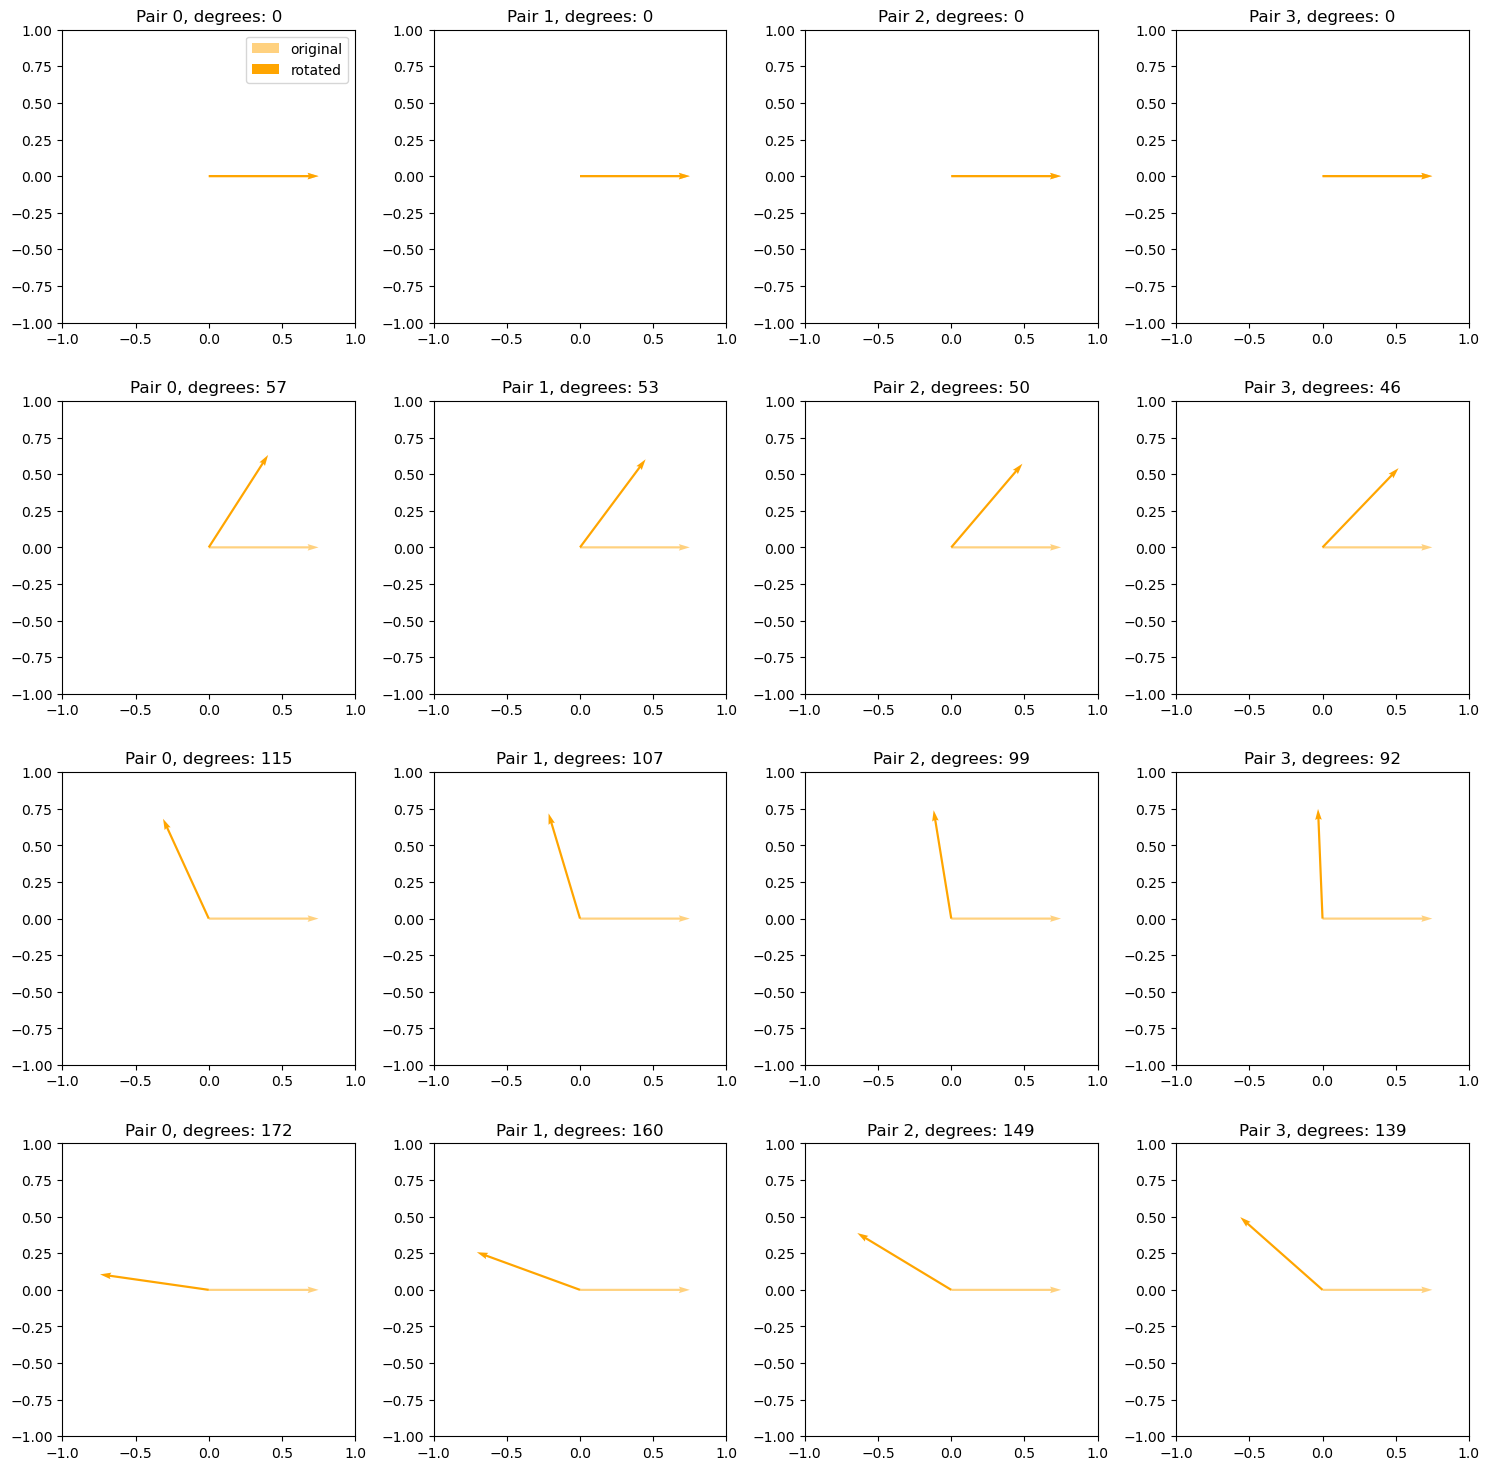

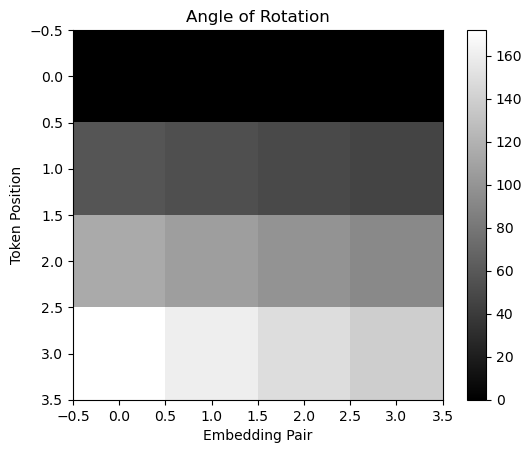

In [75]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

angles = []
for i in range(4):
    angles.append([])
    for j in range(4):
        original_vector = vectors[0, i, 0, j * 2 : (j + 1) * 2]
        rotated_vector = vectors_rotated[0, i, 0, j * 2 : (j + 1) * 2]

        angle = torch.atan2(rotated_vector[1], rotated_vector[0]) - torch.atan2(original_vector[1], original_vector[0])
        if angle < 0:
            angle += 2 * torch.pi
        angle = torch.rad2deg(angle)
        print(f"{angle.item():.02f}", end=" ")
        angles[-1].append(angle.item())

        axs[i, j].quiver(
            0,
            0,
            original_vector[0],
            original_vector[1],
            angles="xy",
            scale_units="xy",
            scale=1,
            label=f"original",
            color="orange",
            linestyle="--",
            alpha=0.5,
        )
        axs[i, j].quiver(
            0,
            0,
            rotated_vector[0],
            rotated_vector[1],
            angles="xy",
            scale_units="xy",
            scale=1,
            label=f"rotated",
            color="orange",
        )
        # axs[i, j].grid()
        axs[i, j].set_xlim(-1, 1)
        axs[i, j].set_ylim(-1, 1)
        axs[i, j].set_title(f"Pair {j}, degrees: {angle:.0f}")
        axs[i, j].set_aspect("equal")
    print()
plt.tight_layout()
axs[0, 0].legend()
plt.tight_layout()
plt.show()

plt.imshow(angles, cmap="gray")
plt.colorbar()
plt.title("Angle of Rotation")
plt.xlabel("Embedding Pair")
plt.ylabel("Token Position")
plt.show()

### Comparing with torchtune's RotaryPositionEmbeddings

In [1]:
from torchtune.modules import RotaryPositionalEmbeddings

ImportError: cannot import name 'FileEncryptionProperties' from 'pyarrow._parquet' (/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/pyarrow/_parquet.cpython-38-darwin.so)

In [ ]:
RotaryPositionalEmbeddings